# Table of Contents
 <p><div class="lev1"><a href="#Task-1.-Compiling-Ebola-Data"><span class="toc-item-num">Task 1.&nbsp;&nbsp;</span>Compiling Ebola Data</a></div>
 <div class="lev1"><a href="#Task-2.-RNA-Sequences"><span class="toc-item-num">Task 2.&nbsp;&nbsp;</span>RNA Sequences</a></div>
 <div class="lev1"><a href="#Task-3.-Class-War-in-Titanic"><span class="toc-item-num">Task 3.&nbsp;&nbsp;</span>Class War in Titanic</a></div></p>

In [2]:
DATA_FOLDER = 'Data' # Use the data folder provided in Tutorial 02 - Intro to Pandas.

In [3]:
# Useful imports
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os #I want to read all files in doc automaticaly

## Task 1. Compiling Ebola Data

The `DATA_FOLDER/ebola` folder contains summarized reports of Ebola cases from three countries (Guinea, Liberia and Sierra Leone) during the recent outbreak of the disease in West Africa. For each country, there are daily reports that contain various information about the outbreak in several cities in each country.

Use pandas to import these data files into a single `Dataframe`.
Using this `DataFrame`, calculate for *each country*, the *daily average per month* of *new cases* and *deaths*.
Make sure you handle all the different expressions for *new cases* and *deaths* that are used in the reports.

# Answer Comentary:

As all the csv files are structured in very different ways, I cleaned all data for each country individualy before merging it into one dataframe.

In [10]:
path = DATA_FOLDER + '/ebola/'

#I procede to go though each folder, starting with guinea

guinea_frame = pd.DataFrame()
for filename in os.listdir(path+'guinea_data'):
    frame = pd.read_csv(path+'guinea_data/'+filename, parse_dates=['Date'],
                        usecols=['Date', 'Description', 'Totals'])#keep only the 3 relevant colums
    
    deaths = frame[['New deaths registered' in d for d in frame.Description]
                  ][['Date', 'Totals']].drop_duplicates(subset='Date')
    
    cases= frame[['Total new cases' in d for d in frame.Description]][['Date', 'Totals']]

    deaths.columns = ['Date', 'Deaths']
    cases.columns = ['Date', 'Cases']
    
    if(cases.shape != deaths.shape):
        raise AssertionError #make sure that we get the same number of values per file
                            #will be one row per date/csv file
    
    total = pd.merge(deaths, cases, on='Date', how='inner')
    total['Date'] = total['Date'].map(lambda x : x.month) #we only want to know about the month (all csv set in 2014)
    guinea_frame = guinea_frame.append(total)

guinea_frame['Country'] = 'Guinea'

#make sure we get some data from every document & we don't miss rows
print('Getting all rows : ',
      guinea_frame.Deaths.shape[0] == len(os.listdir(path+'guinea_data')))


Getting all rows :  True


The next part treats the data from Liberia. Overall, the transcription contains a lot of inconsistencies,
which were adressed by treating cases seperately

In [11]:
liberia_frame = pd.DataFrame()
cumulative_cases = pd.DataFrame()

for filename in os.listdir(path+'liberia_data'):
    frame = pd.read_csv(path+'liberia_data/'+filename, parse_dates=['Date'],
                       usecols=['Date', 'Variable', 'National']) #get only the 3 relevant colums
    
    #one csv contains duplicates on the variable column
    #As the values differ I assumed that the first value is the correct one
    frame = frame.drop_duplicates(subset='Variable') 
    
    deaths = frame[[d in 'Newly reported deaths' for d in frame.Variable]][['Date', 'National']]
    deaths.columns = ['Date', 'Deaths']
    
    #we get all 3 values of new cases (suspected, probable and confirmed) & sum them up
    cases_int = frame[['New Case/s'.lower() in d.lower() for d in frame.Variable]][['Date', 'National']]  
    cases_int.columns = ['Date', 'Cases'] #renaming for convenience
    cases = cases_int.groupby('Date', as_index=False)['Cases'].sum()
    
    #make sure that there is no error in the rows we're getting
    if(cases.shape != deaths.shape):
        raise AssertionError
    
    total = pd.merge(deaths, cases, on='Date', how='inner')  
    total['Date'] = total['Date'].map(lambda x : x.month)
    liberia_frame = liberia_frame.append(total)
    
#in december, the total cases & new cases are exchanged, no values for the new cases are provided
#we approximate those values by taking the difference of total values over multiple dates
liberia_frame.loc[(liberia_frame.Cases > 1000 ),'Cases'] =\
    liberia_frame[[d > 1000 for d in liberia_frame.Cases]]['Cases'].diff(periods=1)

liberia_frame['Country'] = 'Liberia'    

print('Getting all rows : ' , 
      liberia_frame.Deaths.shape[0] == len(os.listdir(path+'liberia_data')))    


Getting all rows :  True


In [12]:
#dealing with sierra leone files

sl_frame = pd.DataFrame()
for filename in os.listdir(path+'sl_data'):
    frame = pd.read_csv(path+'sl_data/'+filename, parse_dates=['date'],
                       usecols=['date', 'variable', 'National'])
    #these csv files do not count the number of new cases
    #we find an approximate value by taking the difference between two consequitive days registered
    deaths = frame[[d in ['death_suspected','death_probable','death_confirmed' ]
                    for d in frame.variable]][['date', 'variable', 'National']]

    deaths.National = deaths.National.astype(float) #as to deal well with nan values
    deaths = deaths.groupby('date', as_index=False)['National'].sum() #summing over 3 possible types of death
    
    
    cases = frame[[d in ['new_suspected','new_probable','new_confirmed' ]
                    for d in frame.variable]][['date', 'variable', 'National']]
    
    cases.dropna(axis='rows') #dealing with na values
    cases.National = cases.National.map(
        lambda x: x if type(x) is float else x.replace(',', '')) #if string contains , remove it
    
    cases.National = cases.National.astype(float) #needed to sum
    cases = cases.groupby('date', as_index=False)['National'].sum()
    
    cases.columns = ['Date', 'Cases']
    deaths.columns = ['Date', 'Total Deaths']
    
    if(cases.shape != deaths.shape):
        raise AssertionError
    
    total = pd.merge(deaths, cases, on='Date', how='inner')  
    total['Date'] = total['Date'].map(lambda x : x.month)
    
    sl_frame = sl_frame.append(total)#aggregate all csv files

sl_frame.reset_index(drop=True, inplace=True)

#calculate new deaths by taking difference between consequitive total deaths
new_deaths = sl_frame['Total Deaths'].diff(periods=1) 

sl_frame['Deaths'] = new_deaths #set new deaths
del sl_frame['Total Deaths']

sl_frame.loc[((sl_frame.Deaths < 0)), 'Deaths'] = float('nan') #clearly we can't have negative deaths
sl_frame.loc[((sl_frame.Deaths > 200)), 'Deaths'] = float('nan')#strong outliers (2) in dataset

sl_frame['Country'] = 'Sierra Leone'

print('Getting all rows : ' , 
    sl_frame.Cases.shape[0] == len(os.listdir(path+'sl_data')))

Getting all rows :  True


Now that we have clean values for all three countries, we can easily put them together and calculate the means

    Date       Country     Deaths      Cases
4      8  Sierra Leone   6.800000  27.944444
7      9  Sierra Leone   5.120000  43.703704
10    10  Sierra Leone  13.760000  70.928571
12    11  Sierra Leone  21.058824  83.157895
14    12  Sierra Leone  53.000000  68.333333
0      6       Liberia   2.000000   5.714286
1      7       Liberia   4.272727   8.545455
3      8       Liberia  23.222222  37.222222
6      9       Liberia  37.608696  63.833333
9     10       Liberia  28.040000  45.560000
11    11       Liberia  15.538462  26.466667
13    12       Liberia        NaN  21.142857
2      8        Guinea   3.400000  25.800000
5      9        Guinea   3.562500  19.625000
8     10        Guinea  15.000000  34.000000


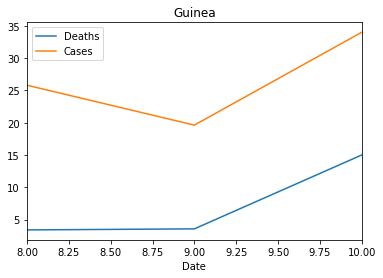

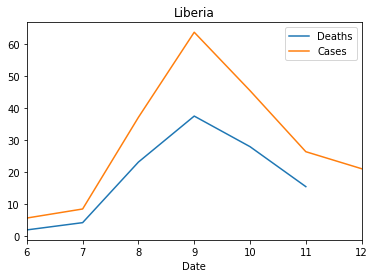

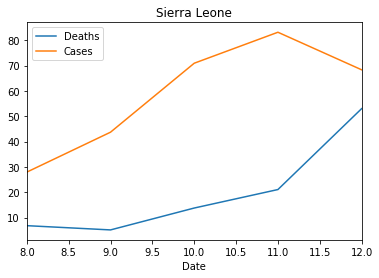

In [13]:
#MERGING ALL FRAMES
ebola_deaths_cases = pd.concat([guinea_frame, liberia_frame, sl_frame]).reset_index(drop=True)
ebola_deaths_cases.Deaths = ebola_deaths_cases.Deaths.astype(float)
ebola_deaths_cases.Cases = ebola_deaths_cases.Cases.astype(float)
means = ebola_deaths_cases.groupby(['Date', 'Country'], as_index=False)[['Deaths', 'Cases']].mean()
#the means we were asked to calculate, sort for convenience
print(means.sort_values(by='Country', ascending=0))

#some figures (for fun!)
plt.figure();
grouped_means = means.groupby('Country')
grouped_means.get_group('Guinea').plot(x='Date', title='Guinea')
grouped_means.get_group('Liberia').plot(x='Date', title='Liberia')
grouped_means.get_group('Sierra Leone').plot(x='Date', title='Sierra Leone')

BONUS answer: 
to make sure the 'cleaned' data makes sense (no negative deaths or cases etc.) I used a simple bar graphs to check at one glance

In [ ]:
ebola_deaths_cases.groupby('Country').plot(x='Date', kind='bar')

## Task 2. RNA Sequences

In the `DATA_FOLDER/microbiome` subdirectory, there are 9 spreadsheets of microbiome data that was acquired from high-throughput RNA sequencing procedures, along with a 10<sup>th</sup> file that describes the content of each. 

Use pandas to import the first 9 spreadsheets into a single `DataFrame`.
Then, add the metadata information from the 10<sup>th</sup> spreadsheet as columns in the combined `DataFrame`.
Make sure that the final `DataFrame` has a unique index and all the `NaN` values have been replaced by the tag `unknown`.

In [ ]:
# Write your answer here

## Task 3. Class War in Titanic

Use pandas to import the data file `Data/titanic.xls`. It contains data on all the passengers that travelled on the Titanic.

In [4]:
from IPython.core.display import HTML
HTML(filename=DATA_FOLDER+'/titanic.html')

# Importing the xls file
titanicXls = pd.read_excel(DATA_FOLDER+'/titanic.xls', header=None)
titanicXls.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
1,1,1,"Allen, Miss. Elisabeth Walton",female,29,0,0,24160,211.338,B5,S,2,NaN,"St Louis, MO"
2,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.55,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Miss. Helen Loraine",female,2,1,2,113781,151.55,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30,1,2,113781,151.55,C22 C26,S,NaN,135,"Montreal, PQ / Chesterville, ON"


For each of the following questions state clearly your assumptions and discuss your findings:
1. Describe the *type* and the *value range* of each attribute. Indicate and transform the attributes that can be `Categorical`. 
2. Plot histograms for the *travel class*, *embarkation port*, *sex* and *age* attributes. For the latter one, use *discrete decade intervals*. 
3. Calculate the proportion of passengers by *cabin floor*. Present your results in a *pie chart*.
4. For each *travel class*, calculate the proportion of the passengers that survived. Present your results in *pie charts*.
5. Calculate the proportion of the passengers that survived by *travel class* and *sex*. Present your results in *a single histogram*.
6. Create 2 equally populated *age categories* and calculate survival proportions by *age category*, *travel class* and *sex*. Present your results in a `DataFrame` with unique index.

- Describe the *type* and the *value range* of each attribute. Indicate and transform the attributes that can be `Categorical`. 

Let's go in order for each colum :
0. pclass is the level they were on: either first, second or third class (1, 2, 3).
1. Survived, which can take either 0 or 1 (so yes or no).
2. Name which can take any string. Begins with a last name, then a comma, than the title (Miss, Mr. Master...) and the first name(s).
3. Sex, which can be either male or female.
4. Age, which can take any number (double).
5. sibsp is the number of siblings aboard of the titanic and can take any integer.
6. parch is the number of parents aboard of the titanic and can take any integer.
7. ticket which is the ticket number. Can take any integer, sometimes preceded with letters. Several members of a same family can share one.
8. fare, which is the amount paid for the ticket (double).
9. cabin which contains the cabin letter and number. Can have several of them.
10. embarked is where somone has embarked and can take the initials S, C or Q.
11. boat which is the escape boat they were on. Can either be an integer, a character, a mix of both or NaN (usually if survived = 0).
12. body which is either a number or NaN. Represent if the body was found and if it was, which number (body indentification number) it was. 
13. home.dest is the destination there were going to. Can take any string (addresses).
(Note that all these informations can be found in the html file).

So with these informations, we can determine which attributes are *Categorical* knowing that they are anything with a fix number that we can simply enumerate. Thus, pclass, survived, sex, cabin, embarked and boat are all categorical.
We could also say that age, fare and body could all be Categorical, as we have a fixed limit of different possibilities for each of them.
Home.dest could have been Categorical if we only had states from the USA (as there is a fixed number of them) but it is harder to transform seeing as we have other destinations (like Canada or France).

- Plot histograms for the *travel class*, *embarkation port*, *sex* and *age* attributes. For the latter one, use *discrete decade intervals*.

In [9]:
pclass = titanicXls[0]
embark = titanicXls[10]
sex = titanicXls[3]
age = titanicXls[4]


- Calculate the proportion of passengers by *cabin floor*. Present your results in a *pie chart*.

- For each *travel class*, calculate the proportion of the passengers that survived. Present your results in *pie charts*.

- Calculate the proportion of the passengers that survived by *travel class* and *sex*. Present your results in *a single histogram*.

- Create 2 equally populated *age categories* and calculate survival proportions by *age category*, *travel class* and *sex*. Present your results in a `DataFrame` with unique index.